In [1]:
#%matplotlib notebook
import os, time, sys
import tables as tb
import matplotlib.pyplot as plt
import numpy as np
import panda2.analysis.interpreter as interpreter
import panda2.analysis.event_builder as event_builder
import panda2.analysis.fitfunctions as fitfunc
import panda2.panda2 as panda2
!ping -c 1 192.168.10.17
dut = panda2.Panda2()
dut.init()
dut.set_conf(INFB=60)

PING 192.168.10.17 (192.168.10.17) 56(84) bytes of data.
64 bytes from 192.168.10.17: icmp_seq=1 ttl=64 time=0.085 ms

--- 192.168.10.17 ping statistics ---
1 packets transmitted, 1 received, 0% packet loss, time 0ms
rtt min/avg/max/mdev = 0.085/0.085/0.085/0.000 ms


2023-06-07 09:47:21,985 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing spi_inj (firmware version: 2), module basil.HL.spi, base_addr 0x10
2023-06-07 09:47:21,986 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing inj (firmware version: 1), module panda2.pulse_gen_div, base_addr 0x100
2023-06-07 09:47:21,987 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing sync (firmware version: 3), module basil.HL.pulse_gen, base_addr 0x140
2023-06-07 09:47:21,988 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing gate (firmware version: 3), module basil.HL.pulse_gen, base_addr 0x180
2023-06-07 09:47:21,988 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing ts_inj (firmware version: 1), module panda2.timestamp_div, base_addr 0x1c0
2023-06-07 09:47:21,989 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing gpio (firmware version: 0), module basil.HL.gpio, base_addr 0x200
20

## With Nwell current

In [16]:
import lab_devices.lab_devices as lab_devices
hv = lab_devices.Smu()
hv.init()
hv.get_values()

2023-06-05 19:42:16,337 - root - [INFO    ] (MainThread) Keysight Technologies,B2901A,MY51141405,3.0.1549.4830


array([-6.500000e+01, -4.950000e-08,  9.910000e+37,  7.214243e+02,
        2.816000e+03, -6.500000e+01], dtype=float32)

In [11]:
hv.get_values(),nw.get_values()

(array([-1.000000e+00, -1.740000e-08,  9.910000e+37,  8.715725e+01,
         2.816000e+03, -1.000000e+00], dtype=float32),
 array([1.800000e+00, 1.300000e-08, 9.910000e+37, 8.839602e+01,
        2.688000e+03, 1.800000e+00], dtype=float32))

In [13]:
#nw.close()
hv.close()

In [15]:
nw = lab_devices.Smu(address = '192.168.10.103')
nw.init()
nw.get_values()

2023-06-05 19:42:16,112 - root - [INFO    ] (MainThread) Keysight Technologies,B2901A,MY51142627,3.1.1645.5820


array([1.799999e+00, 4.670000e-08, 9.910000e+37, 7.222361e+02,
       2.688000e+03, 1.800000e+00], dtype=float32)

In [14]:
nw.close()

In [17]:
volts = np.arange(-65,-200,-1)
ave_n = 10

fname = panda2.mk_fname('iv.h5')
iv_dtype = [('step', '<i4'), ('smu','<u1'), ('volt', '<f4'), ('curr', '<f4'),
            ('res', '<f4'), ('time', '<f4'), ('stat', '<f4'), ('sour', '<f4')]
iv_dtype = np.dtype(iv_dtype)
lab_devices.logger.info('iv_curve:fname={}'.format(fname))
with tb.open_file(fname, 'w') as f:
    iv_tbl = f.create_table(
        f.root,
        description=iv_dtype,
        title='iv',
        name='iv',
        filters=tb.Filters(complib='zlib', complevel=5, fletcher32=False))
    iv_tbl = f.root.iv
    for i, v in enumerate(volts):
        hv.set_voltage(v)
        time.sleep(2)
        for _ in range(ave_n):
            time.sleep(0.1)
            try:
                ret = hv.get_values()
            except:
                hv.close()
                hv.init()
                ret = hv.get_values()
            iv_tbl.row['step'] = i
            iv_tbl.row['smu'] = 0
            for ii, cname in enumerate(iv_dtype.names[2:]):
                iv_tbl.row[cname] = ret[ii]
            iv_tbl.row.append()
            iv_tbl.flush()
            
            try:
                ret2 = nw.get_values()
            except:
                nw.close()
                nw.init()
                ret2 = nw.get_values()
            iv_tbl.row['step'] = i
            iv_tbl.row['smu'] = 1
            lab_devices.logger.info('{0} hv={1}, nw={2}'.format(i, ret, ret2))
            for ii, cname in enumerate(iv_dtype.names[2:]):
                iv_tbl.row[cname] = ret2[ii]
            iv_tbl.row.append()
            iv_tbl.flush()
            
        if np.abs(ret[0] - ret[-1]) > 2.0:
            break
for vv in np.arange(v, 0, 5):
    hv['smu'].set_voltage(vv)
    time.sleep(0.5)
hv['smu'].set_voltage(0)
lab_devices.logger.info('iv_curve:fname={} DONE'.format(fname))

2023-06-05 19:42:29,408 - root - [INFO    ] (MainThread) iv_curve:fname=/home/thirono/Nextcloud-kit/workspace/panda2-daq/scratch/output/iv/20230605_194229_iv.h5
2023-06-05 19:42:29,416 - root - [INFO    ] (MainThread) set_voltage:vol=-65.000V
2023-06-05 19:42:31,926 - root - [INFO    ] (MainThread) 0 hv=[-6.500000e+01 -4.950000e-08  9.910000e+37  7.366043e+02  2.816000e+03
 -6.500000e+01], nw=[1.800000e+00 7.000000e-09 9.910000e+37 7.378451e+02 2.688000e+03
 1.800000e+00]
2023-06-05 19:42:32,455 - root - [INFO    ] (MainThread) 0 hv=[-6.500000e+01 -4.960000e-08  9.910000e+37  7.371131e+02  2.816000e+03
 -6.500000e+01], nw=[1.799999e+00 5.270000e-08 9.910000e+37 7.383722e+02 2.688000e+03
 1.800000e+00]
2023-06-05 19:42:32,972 - root - [INFO    ] (MainThread) 0 hv=[-6.500000e+01 -5.020000e-08  9.910000e+37  7.376428e+02  2.816000e+03
 -6.500000e+01], nw=[1.799998e+00 3.130000e-08 9.910000e+37 7.388890e+02 2.688000e+03
 1.800000e+00]
2023-06-05 19:42:33,488 - root - [INFO    ] (MainThread

2023-06-05 19:42:55,531 - root - [INFO    ] (MainThread) 3 hv=[-6.800000e+01 -5.510000e-08  9.910000e+37  7.602013e+02  2.816000e+03
 -6.800000e+01], nw=[1.800000e+00 3.790000e-08 9.910000e+37 7.614483e+02 2.688000e+03
 1.800000e+00]
2023-06-05 19:42:56,047 - root - [INFO    ] (MainThread) 3 hv=[-6.800000e+01 -5.370000e-08  9.910000e+37  7.607186e+02  2.816000e+03
 -6.800000e+01], nw=[1.799998e+00 3.700000e-08 9.910000e+37 7.619643e+02 2.688000e+03
 1.800000e+00]
2023-06-05 19:42:56,563 - root - [INFO    ] (MainThread) 3 hv=[-6.800000e+01 -5.430000e-08  9.910000e+37  7.612351e+02  2.816000e+03
 -6.800000e+01], nw=[1.800000e+00 1.570000e-08 9.910000e+37 7.624805e+02 2.688000e+03
 1.800000e+00]
2023-06-05 19:42:57,080 - root - [INFO    ] (MainThread) 3 hv=[-6.800000e+01 -5.350000e-08  9.910000e+37  7.617508e+02  2.816000e+03
 -6.800000e+01], nw=[1.800000e+00 2.430000e-08 9.910000e+37 7.629973e+02 2.688000e+03
 1.800000e+00]
2023-06-05 19:42:57,596 - root - [INFO    ] (MainThread) 3 hv=[-

2023-06-05 19:43:19,645 - root - [INFO    ] (MainThread) 6 hv=[-7.100000e+01 -5.640000e-08  9.910000e+37  7.843158e+02  2.816000e+03
 -7.100000e+01], nw=[1.799999e+00 5.810000e-08 9.910000e+37 7.855627e+02 2.688000e+03
 1.800000e+00]
2023-06-05 19:43:19,649 - root - [INFO    ] (MainThread) set_voltage:vol=-72.000V
2023-06-05 19:43:22,160 - root - [INFO    ] (MainThread) 7 hv=[-7.200000e+01 -5.940000e-08  9.910000e+37  7.868366e+02  2.816000e+03
 -7.200000e+01], nw=[1.799998e+00 3.350000e-08 9.910000e+37 7.880776e+02 2.688000e+03
 1.800000e+00]
2023-06-05 19:43:22,688 - root - [INFO    ] (MainThread) 7 hv=[-7.200000e+01 -6.010000e-08  9.910000e+37  7.873481e+02  2.816000e+03
 -7.200000e+01], nw=[1.80000e+00 5.01000e-08 9.91000e+37 7.88605e+02 2.68800e+03 1.80000e+00]
2023-06-05 19:43:23,205 - root - [INFO    ] (MainThread) 7 hv=[-7.200000e+01 -5.930000e-08  9.910000e+37  7.878757e+02  2.816000e+03
 -7.200000e+01], nw=[1.799999e+00 5.890000e-08 9.910000e+37 7.891224e+02 2.688000e+03
 1.8

2023-06-05 19:43:45,253 - root - [INFO    ] (MainThread) 10 hv=[-7.500000e+01 -6.130000e-08  9.910000e+37  8.099232e+02  2.816000e+03
 -7.500000e+01], nw=[1.799998e+00 1.680000e-08 9.910000e+37 8.111693e+02 2.688000e+03
 1.800000e+00]
2023-06-05 19:43:45,770 - root - [INFO    ] (MainThread) 10 hv=[-7.500000e+01 -6.060000e-08  9.910000e+37  8.104394e+02  2.816000e+03
 -7.500000e+01], nw=[1.799999e+00 1.260000e-08 9.910000e+37 8.116863e+02 2.688000e+03
 1.800000e+00]
2023-06-05 19:43:46,286 - root - [INFO    ] (MainThread) 10 hv=[-7.500000e+01 -6.020000e-08  9.910000e+37  8.109562e+02  2.816000e+03
 -7.500000e+01], nw=[1.800000e+00 3.610000e-08 9.910000e+37 8.122024e+02 2.688000e+03
 1.800000e+00]
2023-06-05 19:43:46,802 - root - [INFO    ] (MainThread) 10 hv=[-7.500000e+01 -5.990000e-08  9.910000e+37  8.114725e+02  2.816000e+03
 -7.500000e+01], nw=[1.800000e+00 5.080000e-08 9.910000e+37 8.127184e+02 2.688000e+03
 1.800000e+00]
2023-06-05 19:43:47,319 - root - [INFO    ] (MainThread) 10 

2023-06-05 19:44:08,849 - root - [INFO    ] (MainThread) 13 hv=[-7.800000e+01 -6.350000e-08  9.910000e+37  8.335184e+02  2.816000e+03
 -7.800000e+01], nw=[1.800000e+00 5.570000e-08 9.910000e+37 8.347658e+02 2.688000e+03
 1.800000e+00]
2023-06-05 19:44:09,367 - root - [INFO    ] (MainThread) 13 hv=[-7.800000e+01 -6.320000e-08  9.910000e+37  8.340358e+02  2.816000e+03
 -7.800000e+01], nw=[1.80000e+00 4.86000e-08 9.91000e+37 8.35283e+02 2.68800e+03 1.80000e+00]
2023-06-05 19:44:09,885 - root - [INFO    ] (MainThread) 13 hv=[-7.800000e+01 -6.200000e-08  9.910000e+37  8.345533e+02  2.816000e+03
 -7.800000e+01], nw=[1.799998e+00 1.680000e-08 9.910000e+37 8.357992e+02 2.688000e+03
 1.800000e+00]
2023-06-05 19:44:09,888 - root - [INFO    ] (MainThread) set_voltage:vol=-79.000V
2023-06-05 19:44:12,400 - root - [INFO    ] (MainThread) 14 hv=[-7.900000e+01 -6.710000e-08  9.910000e+37  8.370744e+02  2.816000e+03
 -7.900000e+01], nw=[1.80000e+00 3.16000e-08 9.91000e+37 8.38316e+02 2.68800e+03 1.800

2023-06-05 19:44:34,454 - root - [INFO    ] (MainThread) 17 hv=[-8.200000e+01 -6.950000e-08  9.910000e+37  8.591116e+02  2.816000e+03
 -8.200000e+01], nw=[1.800000e+00 1.050000e-08 9.910000e+37 8.603696e+02 2.688000e+03
 1.800000e+00]
2023-06-05 19:44:34,970 - root - [INFO    ] (MainThread) 17 hv=[-8.200000e+01 -6.750000e-08  9.910000e+37  8.596399e+02  2.816000e+03
 -8.200000e+01], nw=[1.800001e+00 3.190000e-08 9.910000e+37 8.608862e+02 2.688000e+03
 1.800000e+00]
2023-06-05 19:44:35,488 - root - [INFO    ] (MainThread) 17 hv=[-8.200000e+01 -6.850000e-08  9.910000e+37  8.601564e+02  2.816000e+03
 -8.200000e+01], nw=[1.800001e+00 5.760000e-08 9.910000e+37 8.614035e+02 2.688000e+03
 1.800000e+00]
2023-06-05 19:44:36,004 - root - [INFO    ] (MainThread) 17 hv=[-8.200000e+01 -6.680000e-08  9.910000e+37  8.606735e+02  2.816000e+03
 -8.200000e+01], nw=[1.800000e+00 6.590000e-08 9.910000e+37 8.619193e+02 2.688000e+03
 1.800000e+00]
2023-06-05 19:44:36,520 - root - [INFO    ] (MainThread) 17 

2023-06-05 19:44:58,054 - root - [INFO    ] (MainThread) 20 hv=[-8.500000e+01 -7.000000e-08  9.910000e+37  8.827213e+02  2.816000e+03
 -8.500000e+01], nw=[1.800000e+00 5.960000e-08 9.910000e+37 8.839678e+02 2.688000e+03
 1.800000e+00]
2023-06-05 19:44:58,570 - root - [INFO    ] (MainThread) 20 hv=[-8.500000e+01 -6.980000e-08  9.910000e+37  8.832396e+02  2.816000e+03
 -8.500000e+01], nw=[1.799999e+00 4.380000e-08 9.910000e+37 8.844849e+02 2.688000e+03
 1.800000e+00]
2023-06-05 19:44:59,086 - root - [INFO    ] (MainThread) 20 hv=[-8.500000e+01 -7.100000e-08  9.910000e+37  8.837555e+02  2.816000e+03
 -8.500000e+01], nw=[1.800000e+00 3.240000e-08 9.910000e+37 8.850011e+02 2.688000e+03
 1.800000e+00]
2023-06-05 19:44:59,603 - root - [INFO    ] (MainThread) 20 hv=[-8.500000e+01 -7.030000e-08  9.910000e+37  8.842714e+02  2.816000e+03
 -8.500000e+01], nw=[1.800000e+00 5.030000e-08 9.910000e+37 8.855179e+02 2.688000e+03
 1.800000e+00]
2023-06-05 19:45:00,119 - root - [INFO    ] (MainThread) 20 

2023-06-05 19:45:21,648 - root - [INFO    ] (MainThread) 23 hv=[-8.800000e+01 -7.340000e-08  9.910000e+37  9.063164e+02  2.816000e+03
 -8.800000e+01], nw=[1.80000e+00 3.30000e-08 9.91000e+37 9.07563e+02 2.68800e+03 1.80000e+00]
2023-06-05 19:45:21,651 - root - [INFO    ] (MainThread) set_voltage:vol=-89.000V
2023-06-05 19:45:24,163 - root - [INFO    ] (MainThread) 24 hv=[-8.900000e+01 -7.750000e-08  9.910000e+37  9.088364e+02  2.816000e+03
 -8.900000e+01], nw=[1.800000e+00 6.660000e-08 9.910000e+37 9.100777e+02 2.688000e+03
 1.800000e+00]
2023-06-05 19:45:24,690 - root - [INFO    ] (MainThread) 24 hv=[-8.900000e+01 -7.710000e-08  9.910000e+37  9.093477e+02  2.816000e+03
 -8.900000e+01], nw=[1.800000e+00 3.900000e-08 9.910000e+37 9.106048e+02 2.688000e+03
 1.800000e+00]
2023-06-05 19:45:25,207 - root - [INFO    ] (MainThread) 24 hv=[-8.900000e+01 -7.590000e-08  9.910000e+37  9.098751e+02  2.816000e+03
 -8.900000e+01], nw=[1.800000e+00 6.520000e-08 9.910000e+37 9.111218e+02 2.688000e+03


2023-06-05 19:45:47,248 - root - [INFO    ] (MainThread) 27 hv=[-9.200000e+01 -8.000000e-08  9.910000e+37  9.319161e+02  2.816000e+03
 -9.200000e+01], nw=[1.799999e+00 5.980000e-08 9.910000e+37 9.331618e+02 2.688000e+03
 1.800000e+00]
2023-06-05 19:45:47,764 - root - [INFO    ] (MainThread) 27 hv=[-9.200000e+01 -7.950000e-08  9.910000e+37  9.324323e+02  2.816000e+03
 -9.200000e+01], nw=[1.800000e+00 5.720000e-08 9.910000e+37 9.336779e+02 2.688000e+03
 1.800000e+00]
2023-06-05 19:45:48,281 - root - [INFO    ] (MainThread) 27 hv=[-9.200000e+01 -8.000000e-08  9.910000e+37  9.329483e+02  2.816000e+03
 -9.200000e+01], nw=[1.799999e+00 4.160000e-08 9.910000e+37 9.341949e+02 2.688000e+03
 1.800000e+00]
2023-06-05 19:45:48,798 - root - [INFO    ] (MainThread) 27 hv=[-9.200000e+01 -7.940000e-08  9.910000e+37  9.334649e+02  2.816000e+03
 -9.200000e+01], nw=[1.800000e+00 5.120000e-08 9.910000e+37 9.347119e+02 2.688000e+03
 1.800000e+00]
2023-06-05 19:45:49,314 - root - [INFO    ] (MainThread) 27 

2023-06-05 19:46:10,841 - root - [INFO    ] (MainThread) 30 hv=[-9.500000e+01 -8.440000e-08  9.910000e+37  9.555087e+02  2.816000e+03
 -9.500000e+01], nw=[1.799999e+00 3.800000e-08 9.910000e+37 9.567549e+02 2.688000e+03
 1.800000e+00]
2023-06-05 19:46:11,358 - root - [INFO    ] (MainThread) 30 hv=[-9.500000e+01 -8.420000e-08  9.910000e+37  9.560253e+02  2.816000e+03
 -9.500000e+01], nw=[1.799999e+00 1.149000e-07 9.910000e+37 9.572718e+02 2.688000e+03
 1.800000e+00]
2023-06-05 19:46:11,874 - root - [INFO    ] (MainThread) 30 hv=[-9.500000e+01 -8.460000e-08  9.910000e+37  9.565417e+02  2.816000e+03
 -9.500000e+01], nw=[1.800000e+00 5.790000e-08 9.910000e+37 9.577881e+02 2.688000e+03
 1.800000e+00]
2023-06-05 19:46:11,877 - root - [INFO    ] (MainThread) set_voltage:vol=-96.000V
2023-06-05 19:46:14,390 - root - [INFO    ] (MainThread) 31 hv=[-9.600000e+01 -8.800000e-08  9.910000e+37  9.590619e+02  2.816000e+03
 -9.600000e+01], nw=[1.799999e+00 5.590000e-08 9.910000e+37 9.603035e+02 2.6880

2023-06-05 19:46:36,515 - root - [INFO    ] (MainThread) 34 hv=[-9.900000e+01 -9.290000e-08  9.910000e+37  9.811691e+02  2.816000e+03
 -9.900000e+01], nw=[1.800000e+00 5.550000e-08 9.910000e+37 9.824279e+02 2.688000e+03
 1.800000e+00]
2023-06-05 19:46:37,031 - root - [INFO    ] (MainThread) 34 hv=[-9.900000e+01 -9.320000e-08  9.910000e+37  9.816984e+02  2.816000e+03
 -9.900000e+01], nw=[1.800000e+00 4.550000e-08 9.910000e+37 9.829445e+02 2.688000e+03
 1.800000e+00]
2023-06-05 19:46:37,548 - root - [INFO    ] (MainThread) 34 hv=[-9.90000e+01 -9.27000e-08  9.91000e+37  9.82215e+02  2.81600e+03
 -9.90000e+01], nw=[1.800000e+00 5.690000e-08 9.910000e+37 9.834613e+02 2.688000e+03
 1.800000e+00]
2023-06-05 19:46:38,064 - root - [INFO    ] (MainThread) 34 hv=[-9.900000e+01 -9.260000e-08  9.910000e+37  9.827311e+02  2.816000e+03
 -9.900000e+01], nw=[1.799999e+00 6.160000e-08 9.910000e+37 9.839775e+02 2.688000e+03
 1.800000e+00]
2023-06-05 19:46:38,581 - root - [INFO    ] (MainThread) 34 hv=[-9

2023-06-05 19:47:00,119 - root - [INFO    ] (MainThread) 37 hv=[-1.020000e+02 -9.960000e-08  9.910000e+37  1.004785e+03  2.816000e+03
 -1.020000e+02], nw=[1.799999e+00 5.700000e-08 9.910000e+37 1.006031e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:47:00,634 - root - [INFO    ] (MainThread) 37 hv=[-1.020000e+02 -9.950000e-08  9.910000e+37  1.005302e+03  2.816000e+03
 -1.020000e+02], nw=[1.799999e+00 6.100000e-08 9.910000e+37 1.006547e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:47:01,152 - root - [INFO    ] (MainThread) 37 hv=[-1.020000e+02 -9.900000e-08  9.910000e+37  1.005818e+03  2.816000e+03
 -1.020000e+02], nw=[1.800001e+00 6.530000e-08 9.910000e+37 1.007065e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:47:01,668 - root - [INFO    ] (MainThread) 37 hv=[-1.020000e+02 -9.860000e-08  9.910000e+37  1.006335e+03  2.816000e+03
 -1.020000e+02], nw=[1.800000e+00 5.260000e-08 9.910000e+37 1.007581e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:47:02,185 - root - [INFO    ] (MainThread) 37 

2023-06-05 19:47:23,714 - root - [INFO    ] (MainThread) set_voltage:vol=-106.000V
2023-06-05 19:47:26,226 - root - [INFO    ] (MainThread) 41 hv=[-1.060000e+02 -1.118000e-07  9.910000e+37  1.030897e+03  2.816000e+03
 -1.060000e+02], nw=[1.800000e+00 6.870000e-08 9.910000e+37 1.032139e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:47:26,757 - root - [INFO    ] (MainThread) 41 hv=[-1.060000e+02 -1.115000e-07  9.910000e+37  1.031409e+03  2.816000e+03
 -1.060000e+02], nw=[1.799999e+00 5.110000e-08 9.910000e+37 1.032667e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:47:27,272 - root - [INFO    ] (MainThread) 41 hv=[-1.060000e+02 -1.108000e-07  9.910000e+37  1.031939e+03  2.816000e+03
 -1.060000e+02], nw=[1.799999e+00 4.700000e-08 9.910000e+37 1.033184e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:47:27,788 - root - [INFO    ] (MainThread) 41 hv=[-1.060000e+02 -1.106000e-07  9.910000e+37  1.032455e+03  2.816000e+03
 -1.060000e+02], nw=[1.8000e+00 6.5700e-08 9.9100e+37 1.0337e+03 2.6880e+03 1.

2023-06-05 19:47:49,830 - root - [INFO    ] (MainThread) 44 hv=[-1.090000e+02 -1.211000e-07  9.910000e+37  1.054495e+03  2.816000e+03
 -1.090000e+02], nw=[1.799997e+00 5.960000e-08 9.910000e+37 1.055742e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:47:50,347 - root - [INFO    ] (MainThread) 44 hv=[-1.090000e+02 -1.221000e-07  9.910000e+37  1.055012e+03  2.816000e+03
 -1.090000e+02], nw=[1.799999e+00 4.850000e-08 9.910000e+37 1.056259e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:47:50,864 - root - [INFO    ] (MainThread) 44 hv=[-1.090000e+02 -1.216000e-07  9.910000e+37  1.055529e+03  2.816000e+03
 -1.090000e+02], nw=[1.800001e+00 2.930000e-08 9.910000e+37 1.056775e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:47:51,381 - root - [INFO    ] (MainThread) 44 hv=[-1.090000e+02 -1.213000e-07  9.910000e+37  1.056046e+03  2.816000e+03
 -1.090000e+02], nw=[1.800001e+00 8.470000e-08 9.910000e+37 1.057291e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:47:51,897 - root - [INFO    ] (MainThread) 44 

2023-06-05 19:48:13,433 - root - [INFO    ] (MainThread) 47 hv=[-1.120000e+02 -1.347000e-07  9.910000e+37  1.078099e+03  2.816000e+03
 -1.120000e+02], nw=[1.800000e+00 8.220000e-08 9.910000e+37 1.079345e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:48:13,949 - root - [INFO    ] (MainThread) 47 hv=[-1.120000e+02 -1.346000e-07  9.910000e+37  1.078615e+03  2.816000e+03
 -1.120000e+02], nw=[1.799999e+00 6.580000e-08 9.910000e+37 1.079861e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:48:13,953 - root - [INFO    ] (MainThread) set_voltage:vol=-113.000V
2023-06-05 19:48:16,465 - root - [INFO    ] (MainThread) 48 hv=[-1.130000e+02 -1.418000e-07  9.910000e+37  1.081134e+03  2.816000e+03
 -1.130000e+02], nw=[1.799999e+00 6.060000e-08 9.910000e+37 1.082376e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:48:16,992 - root - [INFO    ] (MainThread) 48 hv=[-1.130000e+02 -1.416000e-07  9.910000e+37  1.081647e+03  2.816000e+03
 -1.130000e+02], nw=[1.799999e+00 9.450000e-08 9.910000e+37 1.082903e+03 2.688

2023-06-05 19:48:39,041 - root - [INFO    ] (MainThread) 51 hv=[-1.160000e+02 -1.623000e-07  9.910000e+37  1.103706e+03  2.816000e+03
 -1.160000e+02], nw=[1.799999e+00 8.320000e-08 9.910000e+37 1.104952e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:48:39,558 - root - [INFO    ] (MainThread) 51 hv=[-1.160000e+02 -1.620000e-07  9.910000e+37  1.104222e+03  2.816000e+03
 -1.160000e+02], nw=[1.799999e+00 6.500000e-08 9.910000e+37 1.105468e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:48:40,074 - root - [INFO    ] (MainThread) 51 hv=[-1.160000e+02 -1.614000e-07  9.910000e+37  1.104739e+03  2.816000e+03
 -1.160000e+02], nw=[1.799999e+00 8.830000e-08 9.910000e+37 1.105984e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:48:40,589 - root - [INFO    ] (MainThread) 51 hv=[-1.160000e+02 -1.608000e-07  9.910000e+37  1.105254e+03  2.816000e+03
 -1.160000e+02], nw=[1.8000e+00 7.8600e-08 9.9100e+37 1.1065e+03 2.6880e+03 1.8000e+00]
2023-06-05 19:48:41,106 - root - [INFO    ] (MainThread) 51 hv=[-1.16000e

2023-06-05 19:49:02,636 - root - [INFO    ] (MainThread) 54 hv=[-1.1900e+02 -1.9360e-07  9.9100e+37  1.1273e+03  2.8160e+03 -1.1900e+02], nw=[1.799999e+00 9.670000e-08 9.910000e+37 1.128546e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:49:03,153 - root - [INFO    ] (MainThread) 54 hv=[-1.190000e+02 -1.927000e-07  9.910000e+37  1.127816e+03  2.816000e+03
 -1.190000e+02], nw=[1.800000e+00 1.051000e-07 9.910000e+37 1.129063e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:49:03,670 - root - [INFO    ] (MainThread) 54 hv=[-1.190000e+02 -1.927000e-07  9.910000e+37  1.128334e+03  2.816000e+03
 -1.190000e+02], nw=[1.80000e+00 9.44000e-08 9.91000e+37 1.12958e+03 2.68800e+03 1.80000e+00]
2023-06-05 19:49:04,186 - root - [INFO    ] (MainThread) 54 hv=[-1.19000e+02 -1.93200e-07  9.91000e+37  1.12885e+03  2.81600e+03
 -1.19000e+02], nw=[1.800000e+00 4.550000e-08 9.910000e+37 1.130096e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:49:04,189 - root - [INFO    ] (MainThread) set_voltage:vol=-120.000V
202

2023-06-05 19:49:28,234 - root - [INFO    ] (MainThread) 58 hv=[-1.230000e+02 -2.999000e-07  9.910000e+37  1.152902e+03  2.816000e+03
 -1.230000e+02], nw=[1.799999e+00 8.210000e-08 9.910000e+37 1.154144e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:49:28,763 - root - [INFO    ] (MainThread) 58 hv=[-1.230000e+02 -3.004000e-07  9.910000e+37  1.153414e+03  2.816000e+03
 -1.230000e+02], nw=[1.800000e+00 8.780000e-08 9.910000e+37 1.154672e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:49:29,279 - root - [INFO    ] (MainThread) 58 hv=[-1.230000e+02 -3.000000e-07  9.910000e+37  1.153942e+03  2.816000e+03
 -1.230000e+02], nw=[1.799999e+00 8.270000e-08 9.910000e+37 1.155188e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:49:29,796 - root - [INFO    ] (MainThread) 58 hv=[-1.230000e+02 -2.986000e-07  9.910000e+37  1.154459e+03  2.816000e+03
 -1.230000e+02], nw=[1.800000e+00 8.990000e-08 9.910000e+37 1.155706e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:49:30,313 - root - [INFO    ] (MainThread) 58 

2023-06-05 19:49:51,843 - root - [INFO    ] (MainThread) 61 hv=[-1.260000e+02 -6.408000e-07  9.910000e+37  1.176505e+03  2.816000e+03
 -1.260000e+02], nw=[1.800000e+00 9.870000e-08 9.910000e+37 1.177753e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:49:52,360 - root - [INFO    ] (MainThread) 61 hv=[-1.260000e+02 -6.403000e-07  9.910000e+37  1.177023e+03  2.816000e+03
 -1.260000e+02], nw=[1.799999e+00 8.650000e-08 9.910000e+37 1.178269e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:49:52,877 - root - [INFO    ] (MainThread) 61 hv=[-1.260000e+02 -6.403000e-07  9.910000e+37  1.177539e+03  2.816000e+03
 -1.260000e+02], nw=[1.799999e+00 9.820000e-08 9.910000e+37 1.178786e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:49:53,393 - root - [INFO    ] (MainThread) 61 hv=[-1.260000e+02 -6.388000e-07  9.910000e+37  1.178056e+03  2.816000e+03
 -1.260000e+02], nw=[1.799999e+00 1.016000e-07 9.910000e+37 1.179302e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:49:53,913 - root - [INFO    ] (MainThread) 61 

2023-06-05 19:50:15,448 - root - [INFO    ] (MainThread) 64 hv=[-1.290000e+02 -1.557100e-06  9.910000e+37  1.200111e+03  2.816000e+03
 -1.290000e+02], nw=[1.799999e+00 1.138000e-07 9.910000e+37 1.201357e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:50:15,964 - root - [INFO    ] (MainThread) 64 hv=[-1.290000e+02 -1.555900e-06  9.910000e+37  1.200628e+03  2.816000e+03
 -1.290000e+02], nw=[1.800000e+00 9.090000e-08 9.910000e+37 1.201873e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:50:15,968 - root - [INFO    ] (MainThread) set_voltage:vol=-130.000V
2023-06-05 19:50:18,480 - root - [INFO    ] (MainThread) 65 hv=[-1.300000e+02 -1.971200e-06  9.910000e+37  1.203147e+03  2.816000e+03
 -1.300000e+02], nw=[1.800000e+00 1.142000e-07 9.910000e+37 1.204389e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:50:19,008 - root - [INFO    ] (MainThread) 65 hv=[-1.300000e+02 -1.969600e-06  9.910000e+37  1.203659e+03  2.816000e+03
 -1.300000e+02], nw=[1.799999e+00 1.171000e-07 9.910000e+37 1.204917e+03 2.688

2023-06-05 19:50:41,060 - root - [INFO    ] (MainThread) 68 hv=[-1.330000e+02 -3.272700e-06  9.910000e+37  1.225721e+03  2.816000e+03
 -1.330000e+02], nw=[1.799999e+00 1.294000e-07 9.910000e+37 1.226968e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:50:41,576 - root - [INFO    ] (MainThread) 68 hv=[-1.330000e+02 -3.272200e-06  9.910000e+37  1.226239e+03  2.816000e+03
 -1.330000e+02], nw=[1.799999e+00 9.470000e-08 9.910000e+37 1.227484e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:50:42,094 - root - [INFO    ] (MainThread) 68 hv=[-1.330000e+02 -3.271000e-06  9.910000e+37  1.226754e+03  2.816000e+03
 -1.330000e+02], nw=[1.800e+00 1.251e-07 9.910e+37 1.228e+03 2.688e+03 1.800e+00]
2023-06-05 19:50:42,610 - root - [INFO    ] (MainThread) 68 hv=[-1.330000e+02 -3.270500e-06  9.910000e+37  1.227272e+03  2.816000e+03
 -1.330000e+02], nw=[1.799999e+00 1.428000e-07 9.910000e+37 1.228516e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:50:43,129 - root - [INFO    ] (MainThread) 68 hv=[-1.330000e+02 -

2023-06-05 19:51:05,180 - root - [INFO    ] (MainThread) 71 hv=[-1.360000e+02 -4.544800e-06  9.910000e+37  1.249841e+03  2.816000e+03
 -1.360000e+02], nw=[1.800000e+00 1.568000e-07 9.910000e+37 1.251088e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:51:05,697 - root - [INFO    ] (MainThread) 71 hv=[-1.360000e+02 -4.544200e-06  9.910000e+37  1.250358e+03  2.816000e+03
 -1.360000e+02], nw=[1.799998e+00 1.562000e-07 9.910000e+37 1.251605e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:51:06,213 - root - [INFO    ] (MainThread) 71 hv=[-1.360000e+02 -4.543500e-06  9.910000e+37  1.250874e+03  2.816000e+03
 -1.360000e+02], nw=[1.799999e+00 1.365000e-07 9.910000e+37 1.252119e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:51:06,217 - root - [INFO    ] (MainThread) set_voltage:vol=-137.000V
2023-06-05 19:51:08,729 - root - [INFO    ] (MainThread) 72 hv=[-1.370000e+02 -4.956500e-06  9.910000e+37  1.253394e+03  2.816000e+03
 -1.370000e+02], nw=[1.800000e+00 1.283000e-07 9.910000e+37 1.254637e+03 2.688

2023-06-05 19:51:30,783 - root - [INFO    ] (MainThread) 75 hv=[-1.400000e+02 -6.114300e-06  9.910000e+37  1.275433e+03  2.816000e+03
 -1.400000e+02], nw=[1.799999e+00 1.858000e-07 9.910000e+37 1.276690e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:51:31,300 - root - [INFO    ] (MainThread) 75 hv=[-1.400000e+02 -6.112900e-06  9.910000e+37  1.275961e+03  2.816000e+03
 -1.400000e+02], nw=[1.799999e+00 1.623000e-07 9.910000e+37 1.277207e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:51:31,816 - root - [INFO    ] (MainThread) 75 hv=[-1.400000e+02 -6.112300e-06  9.910000e+37  1.276478e+03  2.816000e+03
 -1.400000e+02], nw=[1.799999e+00 1.464000e-07 9.910000e+37 1.277724e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:51:32,334 - root - [INFO    ] (MainThread) 75 hv=[-1.400000e+02 -6.112600e-06  9.910000e+37  1.276993e+03  2.816000e+03
 -1.400000e+02], nw=[1.800000e+00 1.857000e-07 9.910000e+37 1.278242e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:51:32,851 - root - [INFO    ] (MainThread) 75 

2023-06-05 19:51:54,392 - root - [INFO    ] (MainThread) 78 hv=[-1.430000e+02 -7.184000e-06  9.910000e+37  1.299052e+03  2.816000e+03
 -1.430000e+02], nw=[1.799999e+00 2.199000e-07 9.910000e+37 1.300298e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:51:54,908 - root - [INFO    ] (MainThread) 78 hv=[-1.430000e+02 -7.184000e-06  9.910000e+37  1.299569e+03  2.816000e+03
 -1.430000e+02], nw=[1.799999e+00 2.074000e-07 9.910000e+37 1.300814e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:51:55,425 - root - [INFO    ] (MainThread) 78 hv=[-1.430000e+02 -7.184500e-06  9.910000e+37  1.300085e+03  2.816000e+03
 -1.430000e+02], nw=[1.800000e+00 2.159000e-07 9.910000e+37 1.301331e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:51:55,940 - root - [INFO    ] (MainThread) 78 hv=[-1.430000e+02 -7.185400e-06  9.910000e+37  1.300602e+03  2.816000e+03
 -1.430000e+02], nw=[1.800000e+00 2.117000e-07 9.910000e+37 1.301847e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:51:56,456 - root - [INFO    ] (MainThread) 78 

2023-06-05 19:54:02,040 - root - [INFO    ] (MainThread) 81 hv=[-1.460000e+02 -8.204900e-06  9.910000e+37  1.426697e+03  2.816000e+03
 -1.460000e+02], nw=[1.800000e+00 2.864000e-07 9.910000e+37 1.427942e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:54:02,559 - root - [INFO    ] (MainThread) 81 hv=[-1.46000e+02 -8.20460e-06  9.91000e+37  1.42722e+03  2.81600e+03
 -1.46000e+02], nw=[1.799999e+00 2.870000e-07 9.910000e+37 1.428463e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:54:03,075 - root - [INFO    ] (MainThread) 81 hv=[-1.460000e+02 -8.204400e-06  9.910000e+37  1.427733e+03  2.816000e+03
 -1.460000e+02], nw=[1.799999e+00 2.679000e-07 9.910000e+37 1.428979e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:54:03,592 - root - [INFO    ] (MainThread) 81 hv=[-1.460000e+02 -8.204300e-06  9.910000e+37  1.428249e+03  2.816000e+03
 -1.460000e+02], nw=[1.799999e+00 2.692000e-07 9.910000e+37 1.429496e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:54:03,595 - root - [INFO    ] (MainThread) set_volta

2023-06-05 19:54:25,136 - root - [INFO    ] (MainThread) set_voltage:vol=-150.000V
2023-06-05 19:54:27,648 - root - [INFO    ] (MainThread) 85 hv=[-1.500000e+02 -9.497800e-06  9.910000e+37  1.452309e+03  2.816000e+03
 -1.500000e+02], nw=[1.800001e+00 4.138000e-07 9.910000e+37 1.453552e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:54:28,177 - root - [INFO    ] (MainThread) 85 hv=[-1.500000e+02 -9.497400e-06  9.910000e+37  1.452822e+03  2.816000e+03
 -1.500000e+02], nw=[1.800000e+00 4.435000e-07 9.910000e+37 1.454081e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:54:28,694 - root - [INFO    ] (MainThread) 85 hv=[-1.50000e+02 -9.49770e-06  9.91000e+37  1.45335e+03  2.81600e+03
 -1.50000e+02], nw=[1.800001e+00 4.719000e-07 9.910000e+37 1.454598e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:54:29,210 - root - [INFO    ] (MainThread) 85 hv=[-1.500000e+02 -9.497700e-06  9.910000e+37  1.453867e+03  2.816000e+03
 -1.500000e+02], nw=[1.799999e+00 4.819000e-07 9.910000e+37 1.455112e+03 2.688000e+0

2023-06-05 19:54:51,270 - root - [INFO    ] (MainThread) 88 hv=[-1.530000e+02 -1.060040e-05  9.910000e+37  1.475927e+03  2.816000e+03
 -1.530000e+02], nw=[1.800000e+00 7.785000e-07 9.910000e+37 1.477173e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:54:51,786 - root - [INFO    ] (MainThread) 88 hv=[-1.530000e+02 -1.060080e-05  9.910000e+37  1.476442e+03  2.816000e+03
 -1.530000e+02], nw=[1.80000e+00 8.24300e-07 9.91000e+37 1.47769e+03 2.68800e+03 1.80000e+00]
2023-06-05 19:54:52,303 - root - [INFO    ] (MainThread) 88 hv=[-1.530000e+02 -1.060220e-05  9.910000e+37  1.476959e+03  2.816000e+03
 -1.530000e+02], nw=[1.799999e+00 8.111000e-07 9.910000e+37 1.478207e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:54:52,820 - root - [INFO    ] (MainThread) 88 hv=[-1.530000e+02 -1.060180e-05  9.910000e+37  1.477476e+03  2.816000e+03
 -1.530000e+02], nw=[1.799997e+00 7.928000e-07 9.910000e+37 1.478723e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:54:53,340 - root - [INFO    ] (MainThread) 88 hv=[-1.

2023-06-05 19:55:14,879 - root - [INFO    ] (MainThread) 91 hv=[-1.560000e+02 -1.206580e-05  9.910000e+37  1.499534e+03  2.816000e+03
 -1.560000e+02], nw=[1.799999e+00 1.574400e-06 9.910000e+37 1.500781e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:55:15,395 - root - [INFO    ] (MainThread) 91 hv=[-1.560000e+02 -1.206560e-05  9.910000e+37  1.500051e+03  2.816000e+03
 -1.560000e+02], nw=[1.799999e+00 1.570900e-06 9.910000e+37 1.501298e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:55:15,399 - root - [INFO    ] (MainThread) set_voltage:vol=-157.000V
2023-06-05 19:55:17,911 - root - [INFO    ] (MainThread) 92 hv=[-1.570000e+02 -1.262850e-05  9.910000e+37  1.502571e+03  2.816000e+03
 -1.570000e+02], nw=[1.799999e+00 1.946600e-06 9.910000e+37 1.503814e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:55:18,440 - root - [INFO    ] (MainThread) 92 hv=[-1.570000e+02 -1.262800e-05  9.910000e+37  1.503084e+03  2.816000e+03
 -1.570000e+02], nw=[1.799999e+00 1.922600e-06 9.910000e+37 1.504342e+03 2.688

2023-06-05 19:55:40,499 - root - [INFO    ] (MainThread) 95 hv=[-1.600000e+02 -1.434500e-05  9.910000e+37  1.525155e+03  2.816000e+03
 -1.600000e+02], nw=[1.800000e+00 2.955200e-06 9.910000e+37 1.526401e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:55:41,016 - root - [INFO    ] (MainThread) 95 hv=[-1.600000e+02 -1.434390e-05  9.910000e+37  1.525671e+03  2.816000e+03
 -1.600000e+02], nw=[1.800000e+00 2.986100e-06 9.910000e+37 1.526919e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:55:41,533 - root - [INFO    ] (MainThread) 95 hv=[-1.600000e+02 -1.434480e-05  9.910000e+37  1.526186e+03  2.816000e+03
 -1.600000e+02], nw=[1.799999e+00 2.984000e-06 9.910000e+37 1.527435e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:55:42,050 - root - [INFO    ] (MainThread) 95 hv=[-1.600000e+02 -1.434510e-05  9.910000e+37  1.526705e+03  2.816000e+03
 -1.600000e+02], nw=[1.799999e+00 2.968000e-06 9.910000e+37 1.527952e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:55:42,566 - root - [INFO    ] (MainThread) 95 

2023-06-05 19:56:04,119 - root - [INFO    ] (MainThread) 98 hv=[-1.630000e+02 -1.596820e-05  9.910000e+37  1.548774e+03  2.816000e+03
 -1.630000e+02], nw=[1.799998e+00 3.915200e-06 9.910000e+37 1.550021e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:56:04,636 - root - [INFO    ] (MainThread) 98 hv=[-1.630000e+02 -1.596830e-05  9.910000e+37  1.549291e+03  2.816000e+03
 -1.630000e+02], nw=[1.799999e+00 3.881600e-06 9.910000e+37 1.550537e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:56:05,152 - root - [INFO    ] (MainThread) 98 hv=[-1.630000e+02 -1.596750e-05  9.910000e+37  1.549807e+03  2.816000e+03
 -1.630000e+02], nw=[1.799999e+00 3.864000e-06 9.910000e+37 1.551054e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:56:05,669 - root - [INFO    ] (MainThread) 98 hv=[-1.630000e+02 -1.596720e-05  9.910000e+37  1.550324e+03  2.816000e+03
 -1.630000e+02], nw=[1.80000e+00 3.88610e-06 9.91000e+37 1.55157e+03 2.68800e+03 1.80000e+00]
2023-06-05 19:56:05,672 - root - [INFO    ] (MainThread) set_voltag

2023-06-05 19:56:27,209 - root - [INFO    ] (MainThread) set_voltage:vol=-167.000V
2023-06-05 19:56:29,722 - root - [INFO    ] (MainThread) 102 hv=[-1.670000e+02 -1.796200e-05  9.910000e+37  1.574381e+03  2.816000e+03
 -1.670000e+02], nw=[1.800000e+00 4.938700e-06 9.910000e+37 1.575624e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:56:30,250 - root - [INFO    ] (MainThread) 102 hv=[-1.670000e+02 -1.796130e-05  9.910000e+37  1.574893e+03  2.816000e+03
 -1.670000e+02], nw=[1.799999e+00 4.932100e-06 9.910000e+37 1.576151e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:56:30,767 - root - [INFO    ] (MainThread) 102 hv=[-1.670000e+02 -1.796170e-05  9.910000e+37  1.575421e+03  2.816000e+03
 -1.670000e+02], nw=[1.799999e+00 4.922600e-06 9.910000e+37 1.576669e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:56:31,284 - root - [INFO    ] (MainThread) 102 hv=[-1.670000e+02 -1.796200e-05  9.910000e+37  1.575938e+03  2.816000e+03
 -1.670000e+02], nw=[1.800000e+00 4.926300e-06 9.910000e+37 1.577186e+03 2

2023-06-05 19:56:53,336 - root - [INFO    ] (MainThread) 105 hv=[-1.70000e+02 -1.93848e-05  9.91000e+37  1.59799e+03  2.81600e+03
 -1.70000e+02], nw=[1.800001e+00 5.619600e-06 9.910000e+37 1.599236e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:56:53,853 - root - [INFO    ] (MainThread) 105 hv=[-1.700000e+02 -1.938530e-05  9.910000e+37  1.598507e+03  2.816000e+03
 -1.700000e+02], nw=[1.800000e+00 5.636500e-06 9.910000e+37 1.599752e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:56:54,370 - root - [INFO    ] (MainThread) 105 hv=[-1.700000e+02 -1.938570e-05  9.910000e+37  1.599023e+03  2.816000e+03
 -1.700000e+02], nw=[1.799999e+00 5.625400e-06 9.910000e+37 1.600269e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:56:54,887 - root - [INFO    ] (MainThread) 105 hv=[-1.700000e+02 -1.938710e-05  9.910000e+37  1.599541e+03  2.816000e+03
 -1.700000e+02], nw=[1.799999e+00 5.596000e-06 9.910000e+37 1.600786e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:56:55,403 - root - [INFO    ] (MainThread) 105 h

2023-06-05 19:57:16,943 - root - [INFO    ] (MainThread) 108 hv=[-1.730000e+02 -2.076450e-05  9.910000e+37  1.621597e+03  2.816000e+03
 -1.730000e+02], nw=[1.800000e+00 6.237800e-06 9.910000e+37 1.622844e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:57:17,460 - root - [INFO    ] (MainThread) 108 hv=[-1.730000e+02 -2.076470e-05  9.910000e+37  1.622113e+03  2.816000e+03
 -1.730000e+02], nw=[1.799999e+00 6.225300e-06 9.910000e+37 1.623361e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:57:17,464 - root - [INFO    ] (MainThread) set_voltage:vol=-174.000V
2023-06-05 19:57:19,977 - root - [INFO    ] (MainThread) 109 hv=[-1.740000e+02 -2.120910e-05  9.910000e+37  1.624634e+03  2.816000e+03
 -1.740000e+02], nw=[1.800000e+00 6.428900e-06 9.910000e+37 1.625877e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:57:20,506 - root - [INFO    ] (MainThread) 109 hv=[-1.740000e+02 -2.121030e-05  9.910000e+37  1.625147e+03  2.816000e+03
 -1.740000e+02], nw=[1.800000e+00 6.427000e-06 9.910000e+37 1.626406e+03 2

2023-06-05 19:57:42,570 - root - [INFO    ] (MainThread) 112 hv=[-1.770000e+02 -2.257120e-05  9.910000e+37  1.647222e+03  2.816000e+03
 -1.770000e+02], nw=[1.799999e+00 7.016600e-06 9.910000e+37 1.648470e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:57:43,090 - root - [INFO    ] (MainThread) 112 hv=[-1.770000e+02 -2.257270e-05  9.910000e+37  1.647746e+03  2.816000e+03
 -1.770000e+02], nw=[1.80000e+00 7.01890e-06 9.91000e+37 1.64899e+03 2.68800e+03 1.80000e+00]
2023-06-05 19:57:43,606 - root - [INFO    ] (MainThread) 112 hv=[-1.770000e+02 -2.257330e-05  9.910000e+37  1.648259e+03  2.816000e+03
 -1.770000e+02], nw=[1.799999e+00 6.991300e-06 9.910000e+37 1.649506e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:57:44,123 - root - [INFO    ] (MainThread) 112 hv=[-1.770000e+02 -2.257540e-05  9.910000e+37  1.648776e+03  2.816000e+03
 -1.770000e+02], nw=[1.799999e+00 6.991800e-06 9.910000e+37 1.650023e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:57:44,639 - root - [INFO    ] (MainThread) 112 hv

2023-06-05 19:58:06,184 - root - [INFO    ] (MainThread) 115 hv=[-1.800000e+02 -2.393740e-05  9.910000e+37  1.670835e+03  2.816000e+03
 -1.800000e+02], nw=[1.800000e+00 7.529800e-06 9.910000e+37 1.672083e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:58:06,701 - root - [INFO    ] (MainThread) 115 hv=[-1.800000e+02 -2.393830e-05  9.910000e+37  1.671352e+03  2.816000e+03
 -1.800000e+02], nw=[1.8000e+00 7.5289e-06 9.9100e+37 1.6726e+03 2.6880e+03 1.8000e+00]
2023-06-05 19:58:07,219 - root - [INFO    ] (MainThread) 115 hv=[-1.800000e+02 -2.393960e-05  9.910000e+37  1.671869e+03  2.816000e+03
 -1.800000e+02], nw=[1.800000e+00 7.578600e-06 9.910000e+37 1.673116e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:58:07,735 - root - [INFO    ] (MainThread) 115 hv=[-1.800000e+02 -2.394040e-05  9.910000e+37  1.672387e+03  2.816000e+03
 -1.800000e+02], nw=[1.799999e+00 7.556100e-06 9.910000e+37 1.673632e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:58:07,738 - root - [INFO    ] (MainThread) set_voltage:

2023-06-05 19:58:29,274 - root - [INFO    ] (MainThread) set_voltage:vol=-184.000V
2023-06-05 19:58:31,786 - root - [INFO    ] (MainThread) 119 hv=[-1.840000e+02 -2.574990e-05  9.910000e+37  1.696442e+03  2.816000e+03
 -1.840000e+02], nw=[1.800000e+00 8.272400e-06 9.910000e+37 1.697685e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:58:32,314 - root - [INFO    ] (MainThread) 119 hv=[-1.840000e+02 -2.575100e-05  9.910000e+37  1.696953e+03  2.816000e+03
 -1.840000e+02], nw=[1.800000e+00 8.276700e-06 9.910000e+37 1.698212e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:58:32,833 - root - [INFO    ] (MainThread) 119 hv=[-1.84000e+02 -2.57544e-05  9.91000e+37  1.69749e+03  2.81600e+03
 -1.84000e+02], nw=[1.800000e+00 8.257700e-06 9.910000e+37 1.698732e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:58:33,349 - root - [INFO    ] (MainThread) 119 hv=[-1.840000e+02 -2.575800e-05  9.910000e+37  1.698001e+03  2.816000e+03
 -1.840000e+02], nw=[1.799999e+00 8.248400e-06 9.910000e+37 1.699248e+03 2.68800

2023-06-05 19:58:55,402 - root - [INFO    ] (MainThread) 122 hv=[-1.870000e+02 -2.717860e-05  9.910000e+37  1.720053e+03  2.816000e+03
 -1.870000e+02], nw=[1.799999e+00 8.813400e-06 9.910000e+37 1.721301e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:58:55,920 - root - [INFO    ] (MainThread) 122 hv=[-1.87000e+02 -2.71809e-05  9.91000e+37  1.72057e+03  2.81600e+03
 -1.87000e+02], nw=[1.800000e+00 8.814100e-06 9.910000e+37 1.721818e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:58:56,437 - root - [INFO    ] (MainThread) 122 hv=[-1.870000e+02 -2.718300e-05  9.910000e+37  1.721087e+03  2.816000e+03
 -1.870000e+02], nw=[1.800000e+00 8.814700e-06 9.910000e+37 1.722335e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:58:56,955 - root - [INFO    ] (MainThread) 122 hv=[-1.870000e+02 -2.718550e-05  9.910000e+37  1.721604e+03  2.816000e+03
 -1.870000e+02], nw=[1.800000e+00 8.819800e-06 9.910000e+37 1.722853e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:58:57,472 - root - [INFO    ] (MainThread) 122 h

2023-06-05 19:59:19,002 - root - [INFO    ] (MainThread) 125 hv=[-1.900000e+02 -2.861760e-05  9.910000e+37  1.743653e+03  2.816000e+03
 -1.900000e+02], nw=[1.799999e+00 9.362300e-06 9.910000e+37 1.744900e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:59:19,520 - root - [INFO    ] (MainThread) 125 hv=[-1.900000e+02 -2.862020e-05  9.910000e+37  1.744167e+03  2.816000e+03
 -1.900000e+02], nw=[1.800000e+00 9.377600e-06 9.910000e+37 1.745417e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:59:19,523 - root - [INFO    ] (MainThread) set_voltage:vol=-191.000V
2023-06-05 19:59:22,035 - root - [INFO    ] (MainThread) 126 hv=[-1.91000e+02 -2.90785e-05  9.91000e+37  1.74669e+03  2.81600e+03
 -1.91000e+02], nw=[1.800000e+00 9.522600e-06 9.910000e+37 1.747933e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:59:22,563 - root - [INFO    ] (MainThread) 126 hv=[-1.910000e+02 -2.908210e-05  9.910000e+37  1.747202e+03  2.816000e+03
 -1.910000e+02], nw=[1.799999e+00 9.563400e-06 9.910000e+37 1.748461e+03 2.68800

2023-06-05 19:59:44,614 - root - [INFO    ] (MainThread) 129 hv=[-1.940000e+02 -3.053710e-05  9.910000e+37  1.769265e+03  2.816000e+03
 -1.940000e+02], nw=[1.799999e+00 1.009240e-05 9.910000e+37 1.770510e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:59:45,130 - root - [INFO    ] (MainThread) 129 hv=[-1.94000e+02 -3.05384e-05  9.91000e+37  1.76978e+03  2.81600e+03
 -1.94000e+02], nw=[1.800000e+00 1.008070e-05 9.910000e+37 1.771027e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:59:45,646 - root - [INFO    ] (MainThread) 129 hv=[-1.940000e+02 -3.054220e-05  9.910000e+37  1.770296e+03  2.816000e+03
 -1.940000e+02], nw=[1.800000e+00 1.008490e-05 9.910000e+37 1.771543e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:59:46,163 - root - [INFO    ] (MainThread) 129 hv=[-1.940000e+02 -3.054660e-05  9.910000e+37  1.770812e+03  2.816000e+03
 -1.940000e+02], nw=[1.799999e+00 1.007640e-05 9.910000e+37 1.772059e+03 2.688000e+03
 1.800000e+00]
2023-06-05 19:59:46,679 - root - [INFO    ] (MainThread) 129 h

2023-06-05 20:00:08,217 - root - [INFO    ] (MainThread) 132 hv=[-1.970000e+02 -3.201700e-05  9.910000e+37  1.792864e+03  2.816000e+03
 -1.970000e+02], nw=[1.800000e+00 1.063000e-05 9.910000e+37 1.794114e+03 2.688000e+03
 1.800000e+00]
2023-06-05 20:00:08,735 - root - [INFO    ] (MainThread) 132 hv=[-1.970000e+02 -3.202110e-05  9.910000e+37  1.793383e+03  2.816000e+03
 -1.970000e+02], nw=[1.800000e+00 1.064130e-05 9.910000e+37 1.794632e+03 2.688000e+03
 1.800000e+00]
2023-06-05 20:00:09,252 - root - [INFO    ] (MainThread) 132 hv=[-1.970000e+02 -3.202480e-05  9.910000e+37  1.793901e+03  2.816000e+03
 -1.970000e+02], nw=[1.800000e+00 1.064080e-05 9.910000e+37 1.795149e+03 2.688000e+03
 1.800000e+00]
2023-06-05 20:00:09,770 - root - [INFO    ] (MainThread) 132 hv=[-1.970000e+02 -3.202770e-05  9.910000e+37  1.794417e+03  2.816000e+03
 -1.970000e+02], nw=[1.799999e+00 1.065860e-05 9.910000e+37 1.795667e+03 2.688000e+03
 1.800000e+00]
2023-06-05 20:00:09,773 - root - [INFO    ] (MainThread)

In [9]:
## HV DOWN
for vv in np.arange(v, 0, 5):
    hv['smu'].set_voltage(vv)
    time.sleep(0.5)
hv['smu'].set_voltage(0)

## HV up to -400V

In [38]:
import lab_devices.lab_devices as lab_devices
hvs = []
hvs.append(lab_devices.Smu())
hvs.append(lab_devices.Smu(address = '192.168.10.103'))
for hv in hvs:
    hv.init()
    print(hv, hv.get_values())

2023-06-06 13:36:48,557 - root - [INFO    ] (MainThread) Keysight Technologies,B2901A,MY51141405,3.0.1549.4830
2023-06-06 13:36:48,766 - root - [INFO    ] (MainThread) Keysight Technologies,B2901A,MY51142627,3.1.1645.5820


{'smu': {}, 'socket': {}} [ 0.000000e+00 -2.400000e-08  9.910000e+37  1.469387e+02  3.328000e+03
  0.000000e+00]
{'smu': {}, 'socket': {}} [ 0.00000e+00 -4.20000e-08  9.91000e+37  6.51936e+04  3.32800e+03
  0.00000e+00]


In [37]:
for hv in hvs:
    hv.close()

In [39]:
volts = np.append( np.arange(-0,-250,-2) , np.arange(-250,-400,-1))
ave_n = 10

fname = panda2.mk_fname('iv.h5')
iv_dtype = [('step', '<i4'), ('smu','<u1'), ('volt', '<f4'), ('curr', '<f4'),
            ('res', '<f4'), ('time', '<f4'), ('stat', '<f4'), ('sour', '<f4')]
iv_dtype = np.dtype(iv_dtype)
lab_devices.logger.info('iv_curve:fname={}'.format(fname))
with tb.open_file(fname, 'w') as f:
    iv_tbl = f.create_table(
        f.root,
        description=iv_dtype,
        title='iv',
        name='iv',
        filters=tb.Filters(complib='zlib', complevel=5, fletcher32=False))
    iv_tbl = f.root.iv
    flg = 0
    for i, v in enumerate(volts):
        for hv in hvs:
            hv.set_voltage(v/len(hvs))
        time.sleep(2)
        for _ in range(ave_n):
            time.sleep(0.1)
            for hv_i, hv in enumerate(hvs):
                try:
                    ret = hv.get_values()
                except:
                    print('reconnect', hv)
                    hv.close()
                    hv.init()
                    ret = hv.get_values()
                iv_tbl.row['step'] = i
                iv_tbl.row['smu'] = hv_i
                for cname_i, cname in enumerate(iv_dtype.names[2:]):
                    iv_tbl.row[cname] = ret[cname_i]
                iv_tbl.row.append()
                iv_tbl.flush()
                if np.abs(ret[0] - ret[-1]) > 2.0/len(hvs):
                    flg = 1
                    break
            if flg == 1:
                break
        if flg== 1:
            break

target = 0
for vv in np.append(np.arange(v, target, 5) + np.array([target])):
    for hv in hvs:
        hv.set_voltage(vv/len(hvs))
        time.sleep(0.5)
        
lab_devices.logger.info('iv_curve:fname={} DONE'.format(fname))

2023-06-06 13:37:02,031 - root - [INFO    ] (MainThread) iv_curve:fname=/home/thirono/Nextcloud-kit/workspace/panda2-daq/scratch/output/iv/20230606_133702_iv.h5
2023-06-06 13:37:02,034 - root - [INFO    ] (MainThread) set_voltage:vol=0.000V
2023-06-06 13:37:02,035 - root - [INFO    ] (MainThread) set_voltage:vol=0.000V
2023-06-06 13:37:09,210 - root - [INFO    ] (MainThread) set_voltage:vol=-1.000V
2023-06-06 13:37:09,213 - root - [INFO    ] (MainThread) set_voltage:vol=-1.000V
2023-06-06 13:37:16,393 - root - [INFO    ] (MainThread) set_voltage:vol=-2.000V
2023-06-06 13:37:16,395 - root - [INFO    ] (MainThread) set_voltage:vol=-2.000V
2023-06-06 13:37:23,573 - root - [INFO    ] (MainThread) set_voltage:vol=-3.000V
2023-06-06 13:37:23,574 - root - [INFO    ] (MainThread) set_voltage:vol=-3.000V
2023-06-06 13:37:30,756 - root - [INFO    ] (MainThread) set_voltage:vol=-4.000V
2023-06-06 13:37:30,758 - root - [INFO    ] (MainThread) set_voltage:vol=-4.000V
2023-06-06 13:37:37,934 - root 

2023-06-06 13:42:53,875 - root - [INFO    ] (MainThread) set_voltage:vol=-49.000V
2023-06-06 13:43:01,052 - root - [INFO    ] (MainThread) set_voltage:vol=-50.000V
2023-06-06 13:43:01,054 - root - [INFO    ] (MainThread) set_voltage:vol=-50.000V
2023-06-06 13:43:08,233 - root - [INFO    ] (MainThread) set_voltage:vol=-51.000V
2023-06-06 13:43:08,234 - root - [INFO    ] (MainThread) set_voltage:vol=-51.000V
2023-06-06 13:43:15,439 - root - [INFO    ] (MainThread) set_voltage:vol=-52.000V
2023-06-06 13:43:15,440 - root - [INFO    ] (MainThread) set_voltage:vol=-52.000V
2023-06-06 13:43:22,618 - root - [INFO    ] (MainThread) set_voltage:vol=-53.000V
2023-06-06 13:43:22,620 - root - [INFO    ] (MainThread) set_voltage:vol=-53.000V
2023-06-06 13:43:29,797 - root - [INFO    ] (MainThread) set_voltage:vol=-54.000V
2023-06-06 13:43:29,799 - root - [INFO    ] (MainThread) set_voltage:vol=-54.000V
2023-06-06 13:43:36,978 - root - [INFO    ] (MainThread) set_voltage:vol=-55.000V
2023-06-06 13:43

reconnect {'smu': {}, 'socket': {}}


2023-06-06 13:47:16,806 - root - [INFO    ] (MainThread) Keysight Technologies,B2901A,MY51141405,3.0.1549.4830
2023-06-06 13:47:22,018 - root - [ERROR   ] (MainThread) sock.recv timeout sock=<socket.socket fd=65, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('192.168.10.1', 38064), raddr=('192.168.10.103', 5025)>


reconnect {'smu': {}, 'socket': {}}


2023-06-06 13:48:02,401 - root - [INFO    ] (MainThread) Keysight Technologies,B2901A,MY51142627,3.1.1645.5820
2023-06-06 13:48:07,266 - root - [INFO    ] (MainThread) set_voltage:vol=-80.000V
2023-06-06 13:48:07,267 - root - [INFO    ] (MainThread) set_voltage:vol=-80.000V
2023-06-06 13:48:14,439 - root - [INFO    ] (MainThread) set_voltage:vol=-81.000V
2023-06-06 13:48:14,441 - root - [INFO    ] (MainThread) set_voltage:vol=-81.000V
2023-06-06 13:48:21,628 - root - [INFO    ] (MainThread) set_voltage:vol=-82.000V
2023-06-06 13:48:21,629 - root - [INFO    ] (MainThread) set_voltage:vol=-82.000V
2023-06-06 13:48:28,807 - root - [INFO    ] (MainThread) set_voltage:vol=-83.000V
2023-06-06 13:48:28,809 - root - [INFO    ] (MainThread) set_voltage:vol=-83.000V
2023-06-06 13:48:35,989 - root - [INFO    ] (MainThread) set_voltage:vol=-84.000V
2023-06-06 13:48:35,991 - root - [INFO    ] (MainThread) set_voltage:vol=-84.000V
2023-06-06 13:48:43,164 - root - [INFO    ] (MainThread) set_voltage:

2023-06-06 13:53:59,037 - root - [INFO    ] (MainThread) set_voltage:vol=-127.000V
2023-06-06 13:53:59,039 - root - [INFO    ] (MainThread) set_voltage:vol=-127.000V
2023-06-06 13:54:06,214 - root - [INFO    ] (MainThread) set_voltage:vol=-127.500V
2023-06-06 13:54:06,216 - root - [INFO    ] (MainThread) set_voltage:vol=-127.500V
2023-06-06 13:54:13,389 - root - [INFO    ] (MainThread) set_voltage:vol=-128.000V
2023-06-06 13:54:13,391 - root - [INFO    ] (MainThread) set_voltage:vol=-128.000V
2023-06-06 13:54:20,568 - root - [INFO    ] (MainThread) set_voltage:vol=-128.500V
2023-06-06 13:54:20,569 - root - [INFO    ] (MainThread) set_voltage:vol=-128.500V
2023-06-06 13:54:27,746 - root - [INFO    ] (MainThread) set_voltage:vol=-129.000V
2023-06-06 13:54:27,748 - root - [INFO    ] (MainThread) set_voltage:vol=-129.000V
2023-06-06 13:54:34,923 - root - [INFO    ] (MainThread) set_voltage:vol=-129.500V
2023-06-06 13:54:34,924 - root - [INFO    ] (MainThread) set_voltage:vol=-129.500V
2023

reconnect {'smu': {}, 'socket': {}}


2023-06-06 13:58:00,415 - root - [INFO    ] (MainThread) Keysight Technologies,B2901A,MY51141405,3.0.1549.4830
2023-06-06 13:58:05,626 - root - [ERROR   ] (MainThread) sock.recv timeout sock=<socket.socket fd=65, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('192.168.10.1', 48686), raddr=('192.168.10.103', 5025)>


reconnect {'smu': {}, 'socket': {}}


2023-06-06 13:58:45,894 - root - [INFO    ] (MainThread) Keysight Technologies,B2901A,MY51142627,3.1.1645.5820
2023-06-06 13:58:50,760 - root - [INFO    ] (MainThread) set_voltage:vol=-141.000V
2023-06-06 13:58:50,762 - root - [INFO    ] (MainThread) set_voltage:vol=-141.000V
2023-06-06 13:58:57,936 - root - [INFO    ] (MainThread) set_voltage:vol=-141.500V
2023-06-06 13:58:57,937 - root - [INFO    ] (MainThread) set_voltage:vol=-141.500V
2023-06-06 13:59:05,114 - root - [INFO    ] (MainThread) set_voltage:vol=-142.000V
2023-06-06 13:59:05,115 - root - [INFO    ] (MainThread) set_voltage:vol=-142.000V
2023-06-06 13:59:12,287 - root - [INFO    ] (MainThread) set_voltage:vol=-142.500V
2023-06-06 13:59:12,288 - root - [INFO    ] (MainThread) set_voltage:vol=-142.500V
2023-06-06 13:59:19,462 - root - [INFO    ] (MainThread) set_voltage:vol=-143.000V
2023-06-06 13:59:19,463 - root - [INFO    ] (MainThread) set_voltage:vol=-143.000V
2023-06-06 13:59:26,639 - root - [INFO    ] (MainThread) se

2023-06-06 14:04:42,688 - root - [INFO    ] (MainThread) set_voltage:vol=-165.500V
2023-06-06 14:04:42,690 - root - [INFO    ] (MainThread) set_voltage:vol=-165.500V
2023-06-06 14:04:49,877 - root - [INFO    ] (MainThread) set_voltage:vol=-166.000V
2023-06-06 14:04:49,879 - root - [INFO    ] (MainThread) set_voltage:vol=-166.000V
2023-06-06 14:04:57,065 - root - [INFO    ] (MainThread) set_voltage:vol=-166.500V
2023-06-06 14:04:57,066 - root - [INFO    ] (MainThread) set_voltage:vol=-166.500V
2023-06-06 14:05:04,237 - root - [INFO    ] (MainThread) set_voltage:vol=-167.000V
2023-06-06 14:05:04,239 - root - [INFO    ] (MainThread) set_voltage:vol=-167.000V
2023-06-06 14:05:11,421 - root - [INFO    ] (MainThread) set_voltage:vol=-167.500V
2023-06-06 14:05:11,422 - root - [INFO    ] (MainThread) set_voltage:vol=-167.500V
2023-06-06 14:05:18,608 - root - [INFO    ] (MainThread) set_voltage:vol=-168.000V
2023-06-06 14:05:18,609 - root - [INFO    ] (MainThread) set_voltage:vol=-168.000V
2023

2023-06-06 14:07:36,142 - root - [INFO    ] (MainThread) set_voltage:vol=-102.500V
2023-06-06 14:07:36,644 - root - [INFO    ] (MainThread) set_voltage:vol=-100.000V
2023-06-06 14:07:37,146 - root - [INFO    ] (MainThread) set_voltage:vol=-100.000V
2023-06-06 14:07:37,648 - root - [INFO    ] (MainThread) set_voltage:vol=-97.500V
2023-06-06 14:07:38,151 - root - [INFO    ] (MainThread) set_voltage:vol=-97.500V
2023-06-06 14:07:38,653 - root - [INFO    ] (MainThread) set_voltage:vol=-95.000V
2023-06-06 14:07:39,155 - root - [INFO    ] (MainThread) set_voltage:vol=-95.000V
2023-06-06 14:07:39,657 - root - [INFO    ] (MainThread) set_voltage:vol=-92.500V
2023-06-06 14:07:40,159 - root - [INFO    ] (MainThread) set_voltage:vol=-92.500V
2023-06-06 14:07:40,661 - root - [INFO    ] (MainThread) set_voltage:vol=-90.000V
2023-06-06 14:07:41,164 - root - [INFO    ] (MainThread) set_voltage:vol=-90.000V
2023-06-06 14:07:41,666 - root - [INFO    ] (MainThread) set_voltage:vol=-87.500V
2023-06-06 14

In [11]:
## HV DOWN
for vv in np.arange(0, -200, -5):
    for hv in hvs:
        hv.set_voltage(vv/len(hvs))
        time.sleep(0.5)
#for hv in hvs:
#    hv.set_voltage(0)

2023-06-06 12:47:51,984 - root - [INFO    ] (MainThread) set_voltage:vol=0.000V
2023-06-06 12:47:52,488 - root - [INFO    ] (MainThread) set_voltage:vol=0.000V
2023-06-06 12:47:52,990 - root - [INFO    ] (MainThread) set_voltage:vol=-2.500V
2023-06-06 12:47:53,492 - root - [INFO    ] (MainThread) set_voltage:vol=-2.500V
2023-06-06 12:47:53,995 - root - [INFO    ] (MainThread) set_voltage:vol=-5.000V
2023-06-06 12:47:54,496 - root - [INFO    ] (MainThread) set_voltage:vol=-5.000V
2023-06-06 12:47:54,999 - root - [INFO    ] (MainThread) set_voltage:vol=-7.500V
2023-06-06 12:47:55,500 - root - [INFO    ] (MainThread) set_voltage:vol=-7.500V
2023-06-06 12:47:56,002 - root - [INFO    ] (MainThread) set_voltage:vol=-10.000V
2023-06-06 12:47:56,504 - root - [INFO    ] (MainThread) set_voltage:vol=-10.000V
2023-06-06 12:47:57,005 - root - [INFO    ] (MainThread) set_voltage:vol=-12.500V
2023-06-06 12:47:57,507 - root - [INFO    ] (MainThread) set_voltage:vol=-12.500V
2023-06-06 12:47:58,008 - 

In [14]:
tmpdir = '/home/thirono/Nextcloud-kit/workspace/panda2-daq/scratch/output/iv/'
for fname in np.sort(os.listdir(tmpdir)):
    if fname[-3:]!='.h5':
        continue
    with tb.open_file(os.path.join(tmpdir, fname)) as f:
        dat = f.root.iv[:]
        print(fname, len(dat), end = ' ')
        if len(dat)!=0:
            print(np.min(dat['volt']), np.max(dat['volt']))
        else:
            print()

20230605_164222_iv.h5 4000 -199.0 0.0
20230605_170632_iv.h5 2276 -113.0 1.800002
20230605_171901_iv.h5 0 
20230605_171941_iv.h5 1740 -199.0 1.800002
20230605_175918_iv.h5 132 -163.0 1.800001
20230605_193102_iv.h5 12 -10.0 1.8
20230605_193117_iv.h5 10 -1.0 1.8
20230606_121709_iv.h5 0 
20230606_121819_iv.h5 4000 -99.5001 0.0
20230606_125216_iv.h5 4000 -199.4084 -64.9528


## results

In [16]:
import os, time, sys
import tables as tb
import matplotlib.pyplot as plt
import numpy as np
import panda2.analysis.interpreter as interpreter
import panda2.analysis.event_builder as event_builder
import panda2.analysis.fitfunctions as fitfunc
import panda2.panda2 as panda2

datdir = '/home/thirono/Documents/data/2023-06-05'

1 20230605_193150_iv.h5 1310 -65.0 0.0
2 20230605_194229_iv.h5 2700 -199.0 -65.0


(100.0, 200.0)

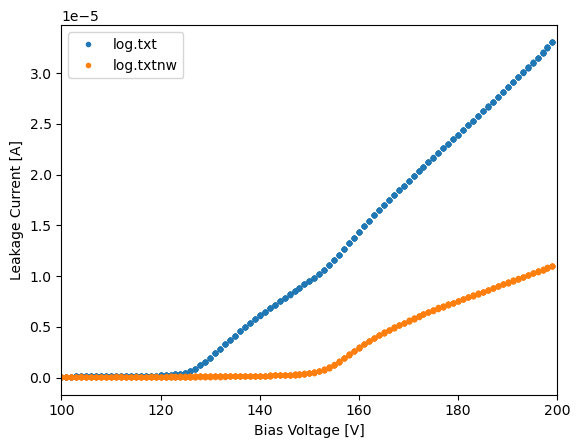

In [30]:
fig, ax = plt.subplots()
for i, fname in enumerate(np.sort(os.listdir(datdir))):
    if fname[-3:]!='.h5':
        continue
    elif fname == '20230605_180125_iv.h5':
        continue
    with tb.open_file(os.path.join(datdir, fname)) as f:
        dat = f.root.iv[:]
        dat_hv = dat[dat['smu']==0]
        dat_nw = dat[dat['smu']==1]
        print(i, fname, len(dat), end = ' ')
        if len(dat)!=0:
            print(np.min(dat_hv['volt']), np.max(dat_hv['volt']))
        else:
            print()
        if i ==1:
            y = dat_hv['curr'][dat_hv['curr']<0]
            x = dat_hv['volt'][dat_hv['curr']<0]
            nw_y = dat_nw['curr'][dat_hv['curr']<0]
        else:
            y = np.append(y, dat_hv['curr'][dat_hv['curr']<0])
            x = np.append(x, dat_hv['volt'][dat_hv['curr']<0])
            nw_y = np.append(nw_y, dat_nw['curr'][dat_hv['curr']<0])   
ax.plot(-x, -y, 'C0.', label=fname, )
ax.plot(-x, nw_y, 'C1.', label=fname+'nw')
#ax.set_yscale('log')
ax.set_xlabel('Bias Voltage [V]')
ax.set_ylabel('Leakage Current [A]')
plt.legend()#
plt.xlim(100,200)

(100.0, 200.0)

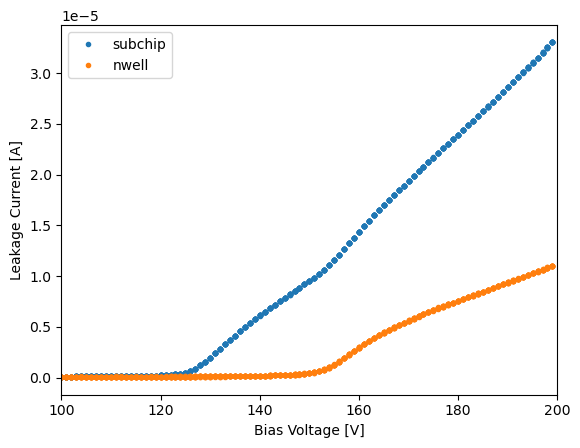

In [41]:
fig, ax = plt.subplots()
ax.plot(-x, -y, 'C0.', label='subchip')
ax.plot(-x, nw_y, 'C1.', label='nwell')
#ax.set_yscale('log')
ax.set_xlabel('Bias Voltage [V]')
ax.set_ylabel('Leakage Current [A]')
plt.legend()
ax.set_xlim(100,200)
#ax.set_ylim(0E-6,10E-6)
#np.bitwise_and(x>-130, y<)

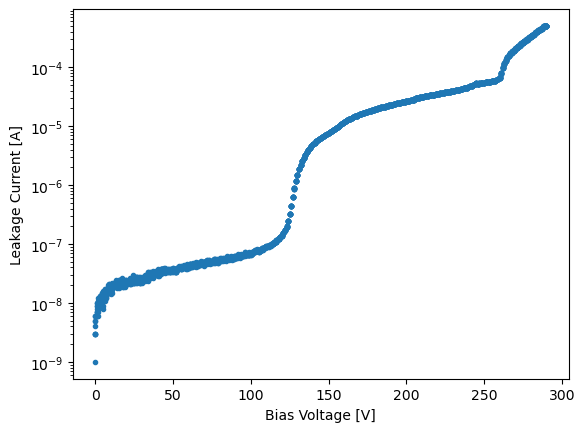

In [76]:
for i, fname in enumerate(['20230531_111328_iv.h5']):
    with tb.open_file(os.path.join(tmpdir,fname)) as f:
        dat = f.root.iv[:]
    arg = np.argwhere(dat['volt'][1:]-dat['volt'][:-1] > 0)[0,0] +1
    y = dat['curr'][:arg][dat['curr'][:arg]<0]
    x = dat['volt'][:arg][dat['curr'][:arg]<0]
    y2 = dat['curr'][arg:][dat['curr'][arg:]<0]
    x2 = dat['volt'][arg:][dat['curr'][arg:]<0]
    x = x - 93
    plt.plot(-x[x<-180],-y[x<-180], 'C0.', label=fname)
    plt.plot(-x2[x2>=-180],-y2[x2>=-180], 'C0.', label=fname)
    plt.yscale('log')
    plt.xlabel('Bias Voltage [V]')
    plt.ylabel('Leakage Current [A]')
#plt.legend()

5 20230606_133702_iv.h5 4520 -152.6981 0.0
0 0


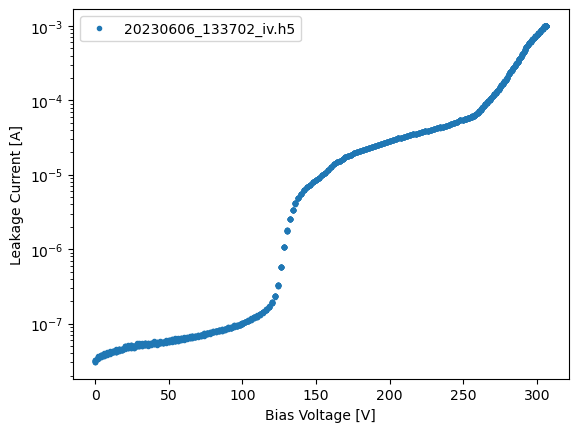

In [51]:
fig, ax = plt.subplots()
for i, fname in enumerate(np.sort(os.listdir(datdir))):
    if fname[-3:]!='.h5':
        continue
    elif i in [0, 1, 2,3,4]:
        continue
    with tb.open_file(os.path.join(datdir, fname)) as f:
        dat = f.root.iv[:]
        dat0 = dat[dat['smu']==0]
        dat1 = dat[dat['smu']==1]
        print(i, fname, len(dat), end = ' ')
        if len(dat)!=0:
            print(np.min(dat_hv['volt']), np.max(dat_hv['volt']))
        else:
            print()
        print(np.sum(dat0['curr']>0), np.sum(dat1['curr']>0))
        y0 = dat0['curr'][dat0['curr']<0]
        x0 = dat0['volt'][dat0['curr']<0]
        y1 = dat1['curr'][dat1['curr']<0]
        x1 = dat1['volt'][dat1['curr']<0]
        ax.plot(-x0-x1, (-y0-y1)/2., '.', label=fname, )
        #ax.plot(-x, nw_y, 'C1.', label=fname+'nw')
ax.set_yscale('log')
ax.set_xlabel('Bias Voltage [V]')
ax.set_ylabel('Leakage Current [A]')
plt.legend()#
#plt.xlim(100,200)